## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## A. Camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
#API to callibrate camera using chess board images

def CallibrateCamera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    #Callibrate camera
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)  


In [3]:
#callibrate images and save it
ret, mtx, dist, rvecs, tvecs = CallibrateCamera()

cali_pickle = {}
cali_pickle["matrix"] = mtx
cali_pickle["distortion"] = dist

fp = open("./output_images/callbration.p","wb")

pickle.dump(cali_pickle, fp)



### do undistortion for all images and save images locally

In [4]:
#wrapper to undistort image

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [5]:
#Apply undistor on image and save 
def run_all():
    images = glob.glob('./camera_cal/calibration*.jpg')
    for fname in images:
        img = cv2.imread(fname)
        dst = undistort(img)
        cv2.imwrite("./output_images" + fname.split('camera_cal')[1], dst)
run_all()


### Plot one of undistorted image

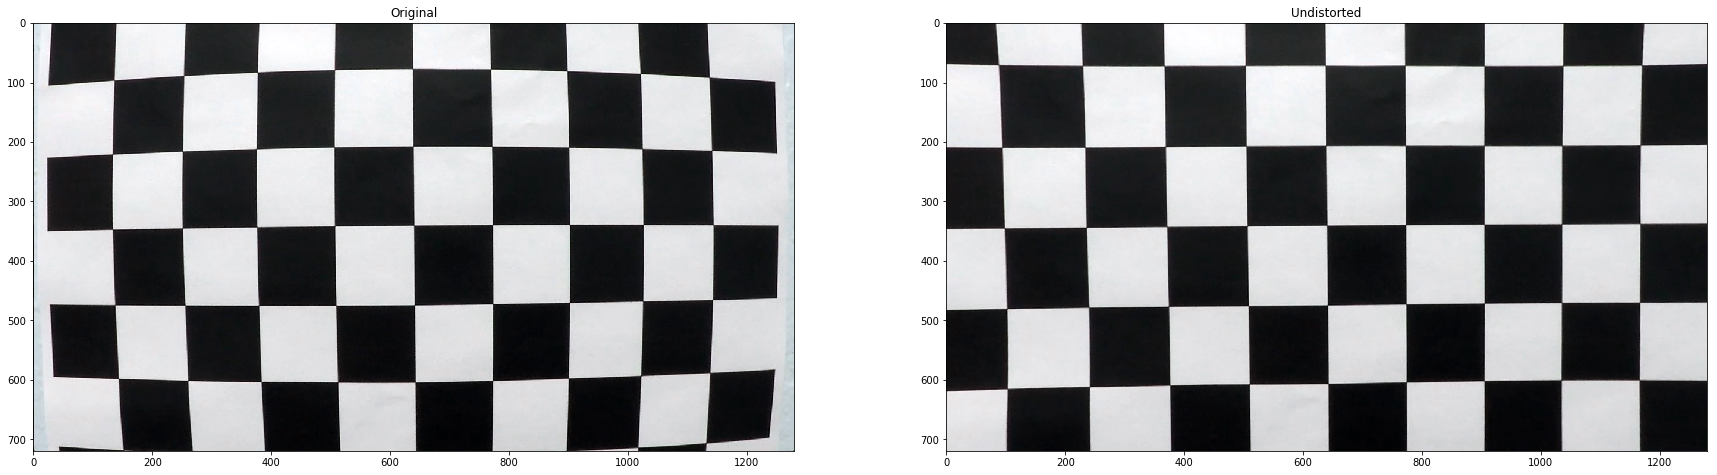

In [6]:
#Plot input and output on first image

def example_plot():
    img = cv2.imread("./camera_cal/calibration1.jpg")
    dst = undistort(img)

    plt.figure(figsize=[30, 40])
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.title("Undistorted")
    plt.imshow(dst)
    plt.savefig("./output_images/p4_1.png")
example_plot()

## B. Pipeline (single images)


### 1a.  Apply distortion correction on each test image
### 1b.  Provide an example of a distortion-corrected image 

In [7]:

def pipeline1():
    images = glob.glob('./test_images/test*.jpg')
    for fname in images:
        img = cv2.imread(fname)
        dst = undistort(img)
        cv2.imwrite("./output_images" + fname.split('test_images')[1], dst)

pipeline1()


distortion correction can be seen at bottom of image


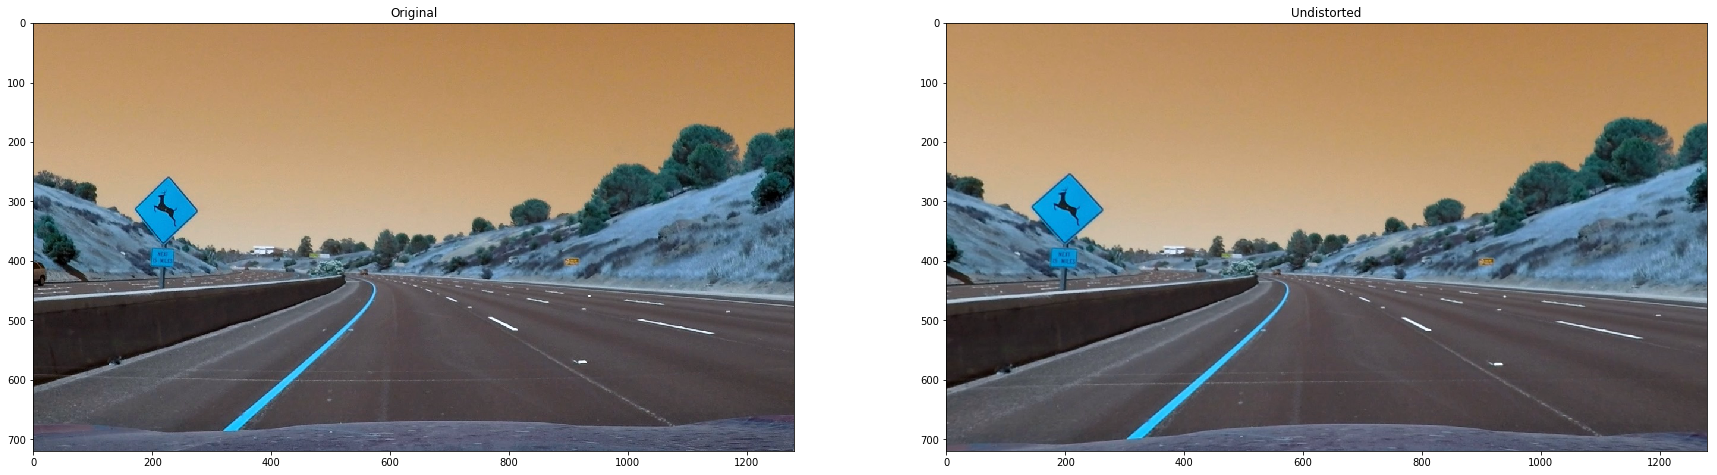

In [8]:
def pipeline2():
    fname = "./test_images/test2.jpg"
    img2 = cv2.imread(fname)
    dst2 = undistort(img2)

    plt.figure(figsize=[30, 40])
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(img2)
    plt.subplot(1, 2, 2)
    plt.title("Undistorted")
    plt.imshow(dst2)
    cv2.imwrite("./output_images/distort.jpg", dst2)
    print ("distortion correction can be seen at bottom of image")
pipeline2()


### Wrapper API for threshold binary image

In [9]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        abs_sobel = np.absolute(sobelx)
    else:
        abs_sobel = np.absolute(sobely)
     
    #Threshold
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    first = np.zeros_like(scaled_sobel)
    first[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        
    return first

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
       
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    #Magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4.a) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # 5.a) Create a binary mask where mag thresholds are met
    second = np.zeros_like(scaled_sobel)
    second[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return second

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
      # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    absx = np.absolute(sobelx)
    absy = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(absy, absx)
    
    # 5) Create a binary mask where direction thresholds are met
    third =  np.zeros_like(absgraddir)
    
    # 6) Return this mask as your binary_output image
    third[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return third

def color(img, s_thresh=(177, 255)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Convert to HLS color space and separate the V channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return s_binary


#Below is referenced from discussion.udacity.com which helped to fix test3.jpg
def color_thresh(image, s_thresh=(0, 255), l_thresh=(0, 255), b_thresh=(0, 255), v_thresh=(0, 255)):
    luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
 #   hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    lab =cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    l_channel = luv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    b_channel = lab[:,:,2]
    
    output = np.zeros_like(s_channel)
    output[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1]) | (l_channel > l_thresh[0]) & (l_channel <=l_thresh[1]) |
    (b_channel>b_thresh[0])& (b_channel <= b_thresh[1]) | (v_channel>v_thresh[0]) & (v_channel<=v_thresh[1])] = 1
    
    return output

def color_thresh2(image, l_thresh=(150, 200), b_thresh=(225, 255)):
    #very simple combination of color based thresholds.
    #The b channel from Lab with thresholds between about 150 and 200 (for yellow lines).
    lab =cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]
    
    #The L channel from LUV with thresholds between about 225 and 255 (for white lines).
    luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    
    output = np.zeros_like(l_channel)
    output[((l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])) | 
           ((b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1]))] = 1
    
    return output

def combine(image):
    #Gradient
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=50, thresh_max=90)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=30, thresh_max=90)
    color_binary = color_thresh(image, s_thresh=(245, 255), l_thresh=(225, 255), b_thresh=(150, 200), v_thresh=(225, 255))
    #color_binary = color_thresh2(image)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30,100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    
    grad = gradx + grady
    combined_grad = np.zeros_like(dir_binary)
    combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    combined_binary = np.zeros_like(gradx)
    #combined_binary[((gradx==1) & (grady==1)) | (color_binary==1)] = 255
    combined_binary[((gradx==1)) | (color_binary==1)] = 255
  
    return image, gradx, grady, mag_binary, dir_binary, combined_grad, color_binary, combined_binary


### 2. thresholded binary image

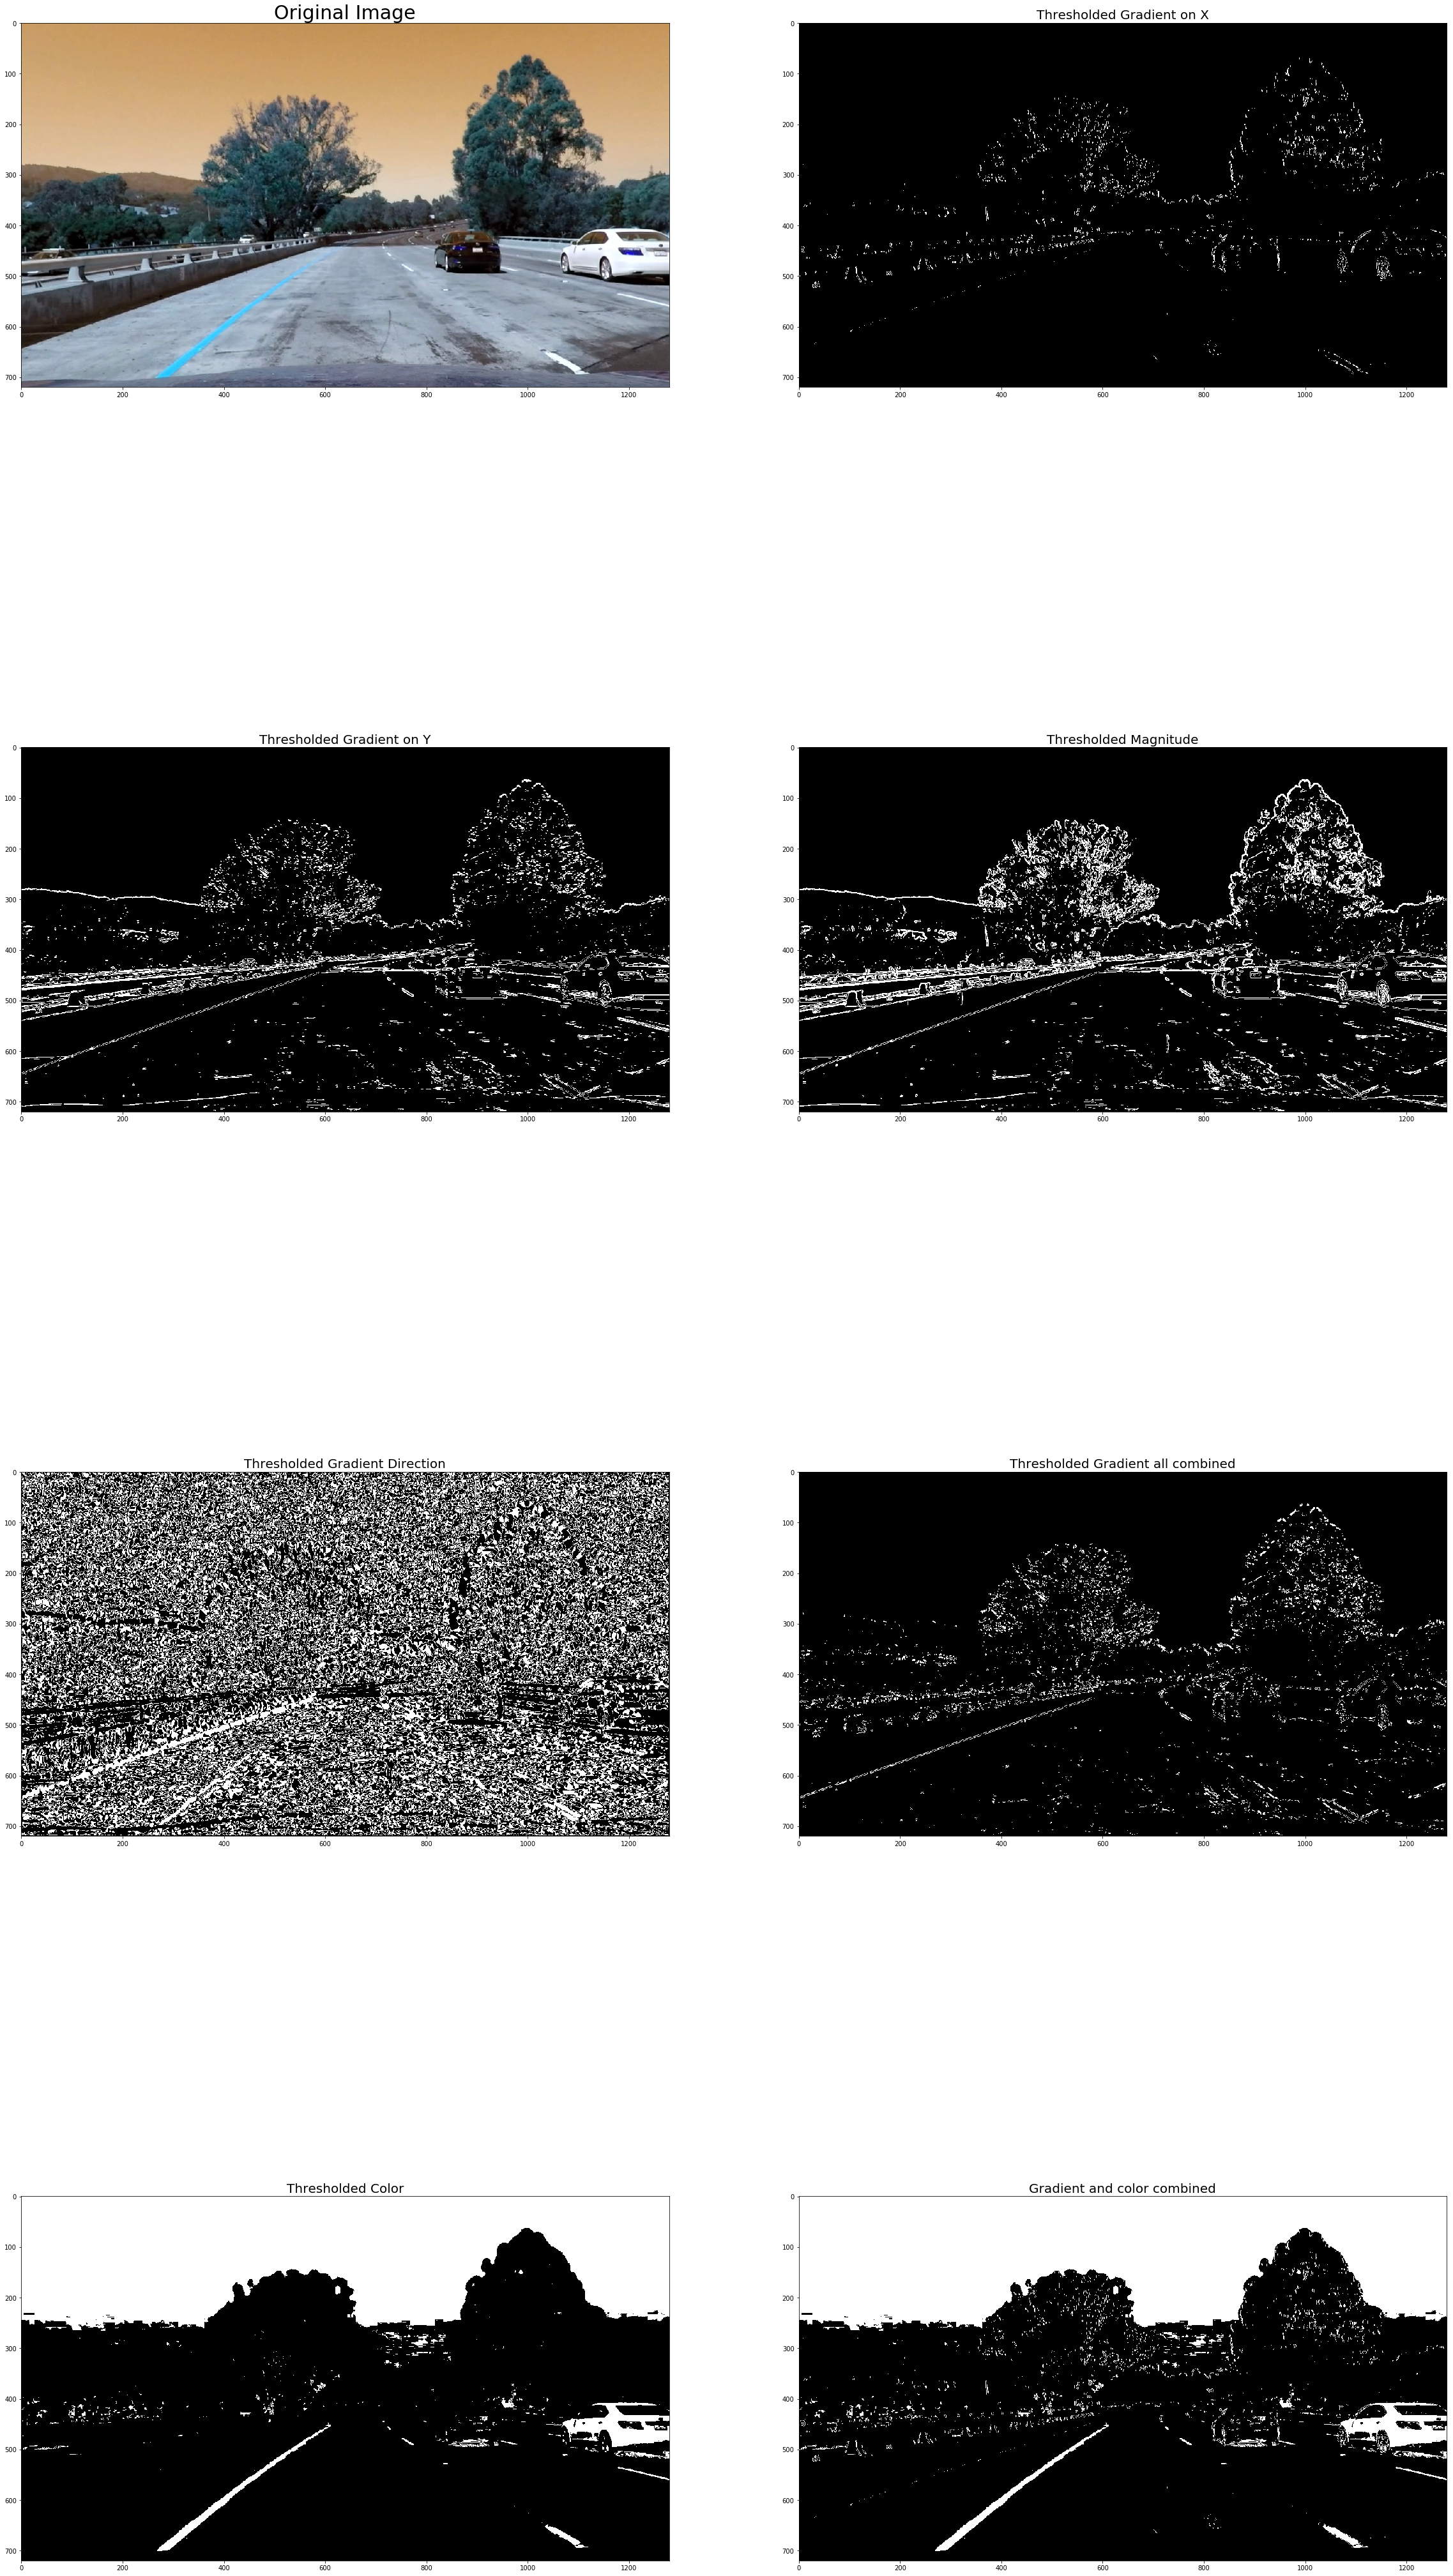

In [10]:
def plot(images):
    # Plot the result
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 2, figsize=(40, 80))
    #f.tight_layout()

    ax1[0].imshow(images[0])
    ax1[0].set_title('Original Image', fontsize=30)

    ax1[1].imshow(images[1], cmap='gray')
    ax1[1].set_title('Thresholded Gradient on X', fontsize=20)

    ax2[0].imshow(images[2], cmap='gray')
    ax2[0].set_title('Thresholded Gradient on Y', fontsize=20)

    ax2[1].imshow(images[3], cmap='gray')
    ax2[1].set_title('Thresholded Magnitude', fontsize=20)

    ax3[0].imshow(images[4], cmap='gray')
    ax3[0].set_title('Thresholded Gradient Direction', fontsize=20)

    ax3[1].imshow(images[5], cmap='gray')
    ax3[1].set_title('Thresholded Gradient all combined', fontsize=20)

    ax4[0].imshow(images[6], cmap='gray')
    ax4[0].set_title('Thresholded Color', fontsize=20)

    ax4[1].imshow(images[7], cmap='gray')
    ax4[1].set_title('Gradient and color combined', fontsize=20)


def pipeline3():
    image = cv2.imread("./test_images/test1.jpg")
    image = undistort(image)
    images = combine(image)
    cv2.imwrite("./output_images/threshold.jpg", images[7])
    plot(images)

pipeline3()

### 3. perspective transform

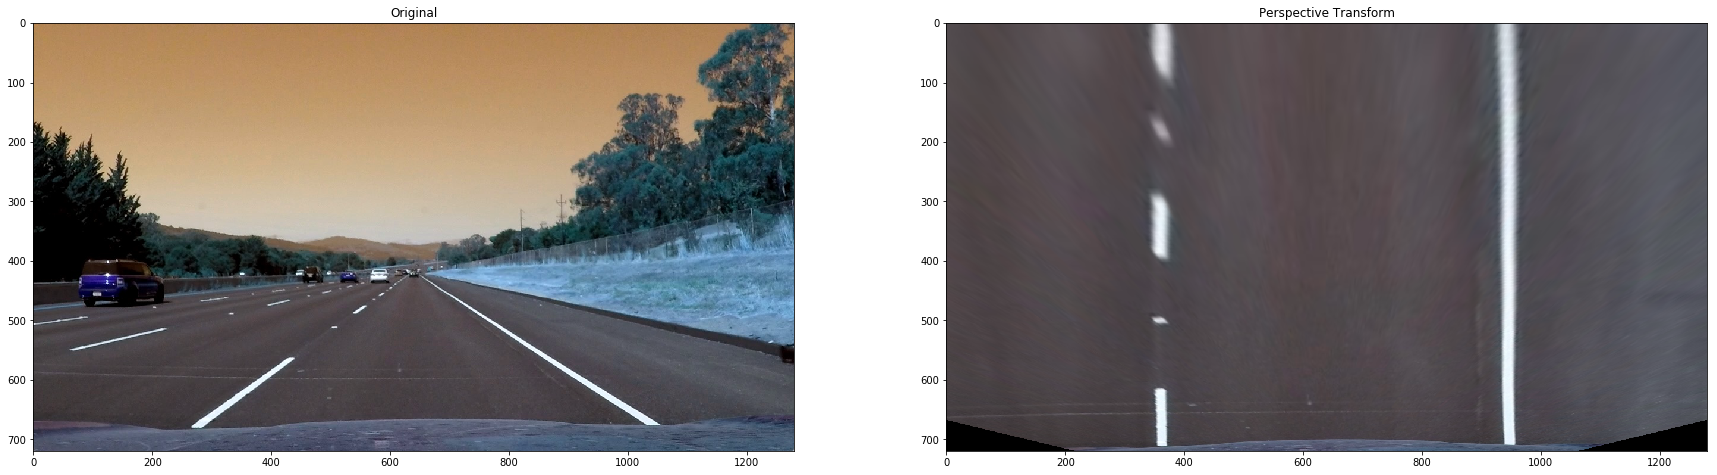

In [11]:

def perspective_transform(img):
    img = undistort(img)
    img_size = (img.shape[1], img.shape[0])

    xff1 = 60 # as copied, this was 55
    xff2 = 60 # as copied, this was 60
    yff = 95 # as copied, this was 100
    src = np.float32(
        [[(img_size[0] / 2) - xff1, img_size[1] / 2 + yff],
         [((img_size[0] / 6) - xff2), img_size[1]],
         [(img_size[0] * 5 / 6) + xff2, img_size[1]],
         [(img_size[0] / 2 + xff1), img_size[1] / 2 + yff]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    
 #   print (src)
  #  print (dst)
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
     
    return warped, M, Minv

def plot2d(inp, output):
    plt.figure(figsize=[30, 40])
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(inp)

    plt.subplot(1, 2, 2)
    plt.title("Perspective Transform")
    plt.imshow(output)
    plt.savefig("./output_images/perspective.jpg")

def pipeline4():
    img = cv2.imread("./test_images/straight_lines2.jpg")
    warped, M, Minv = perspective_transform(img)
    plot2d(img, warped)

pipeline4()

### Wrapper function to locate lines, sliding window, skip sliding window, calucate radius and position of car

In [12]:
def sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img



In [13]:
def polydraw(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img):

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

 #   warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
  #  out_img = np.dstack((warp_zero, warp_zero, warp_zero))
  #  out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Find lane curvature #
    
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
   # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
  

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # print(left_curverad, 'm', right_curverad, 'm')
    radius = np.mean([left_curverad, right_curverad])
    
    return out_img, radius, left_fit, right_fit

In [14]:
def skip_sliding(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
   
    return left_fit, right_fit, left_lane_inds, right_lane_inds


In [15]:
def polydraw_skip_sliding(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    margin = 100
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
      
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return result


In [16]:
def sliding_curve_plot(img):
    images = combine(img)
    warped, M, Minv = perspective_transform(images[7])
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = sliding_window(warped)
    
    sliding_out, radius, left_fit, right_fit = polydraw(warped, left_fit, right_fit, left_lane_inds, right_lane_inds, out_img)
    
    left_fit, right_fit, left_lane_inds, right_lane_inds = skip_sliding(warped, left_fit, right_fit)
    skip_result = polydraw_skip_sliding(warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
    
    #Update radius in image
    text2 = "Radius of Curvature = ~" + str(round(radius, 2)) + " (m)"
    font = cv2.FONT_HERSHEY_SIMPLEX
    result = cv2.putText(sliding_out, text2, (60, 60), font, 1, (0, 0, 255), 3, cv2.LINE_AA)
    
    return images[7], warped, sliding_out, skip_result


### 4. Locate the Lane Lines and Fit a Polynomial.
###   using sliding window and skip sliding window

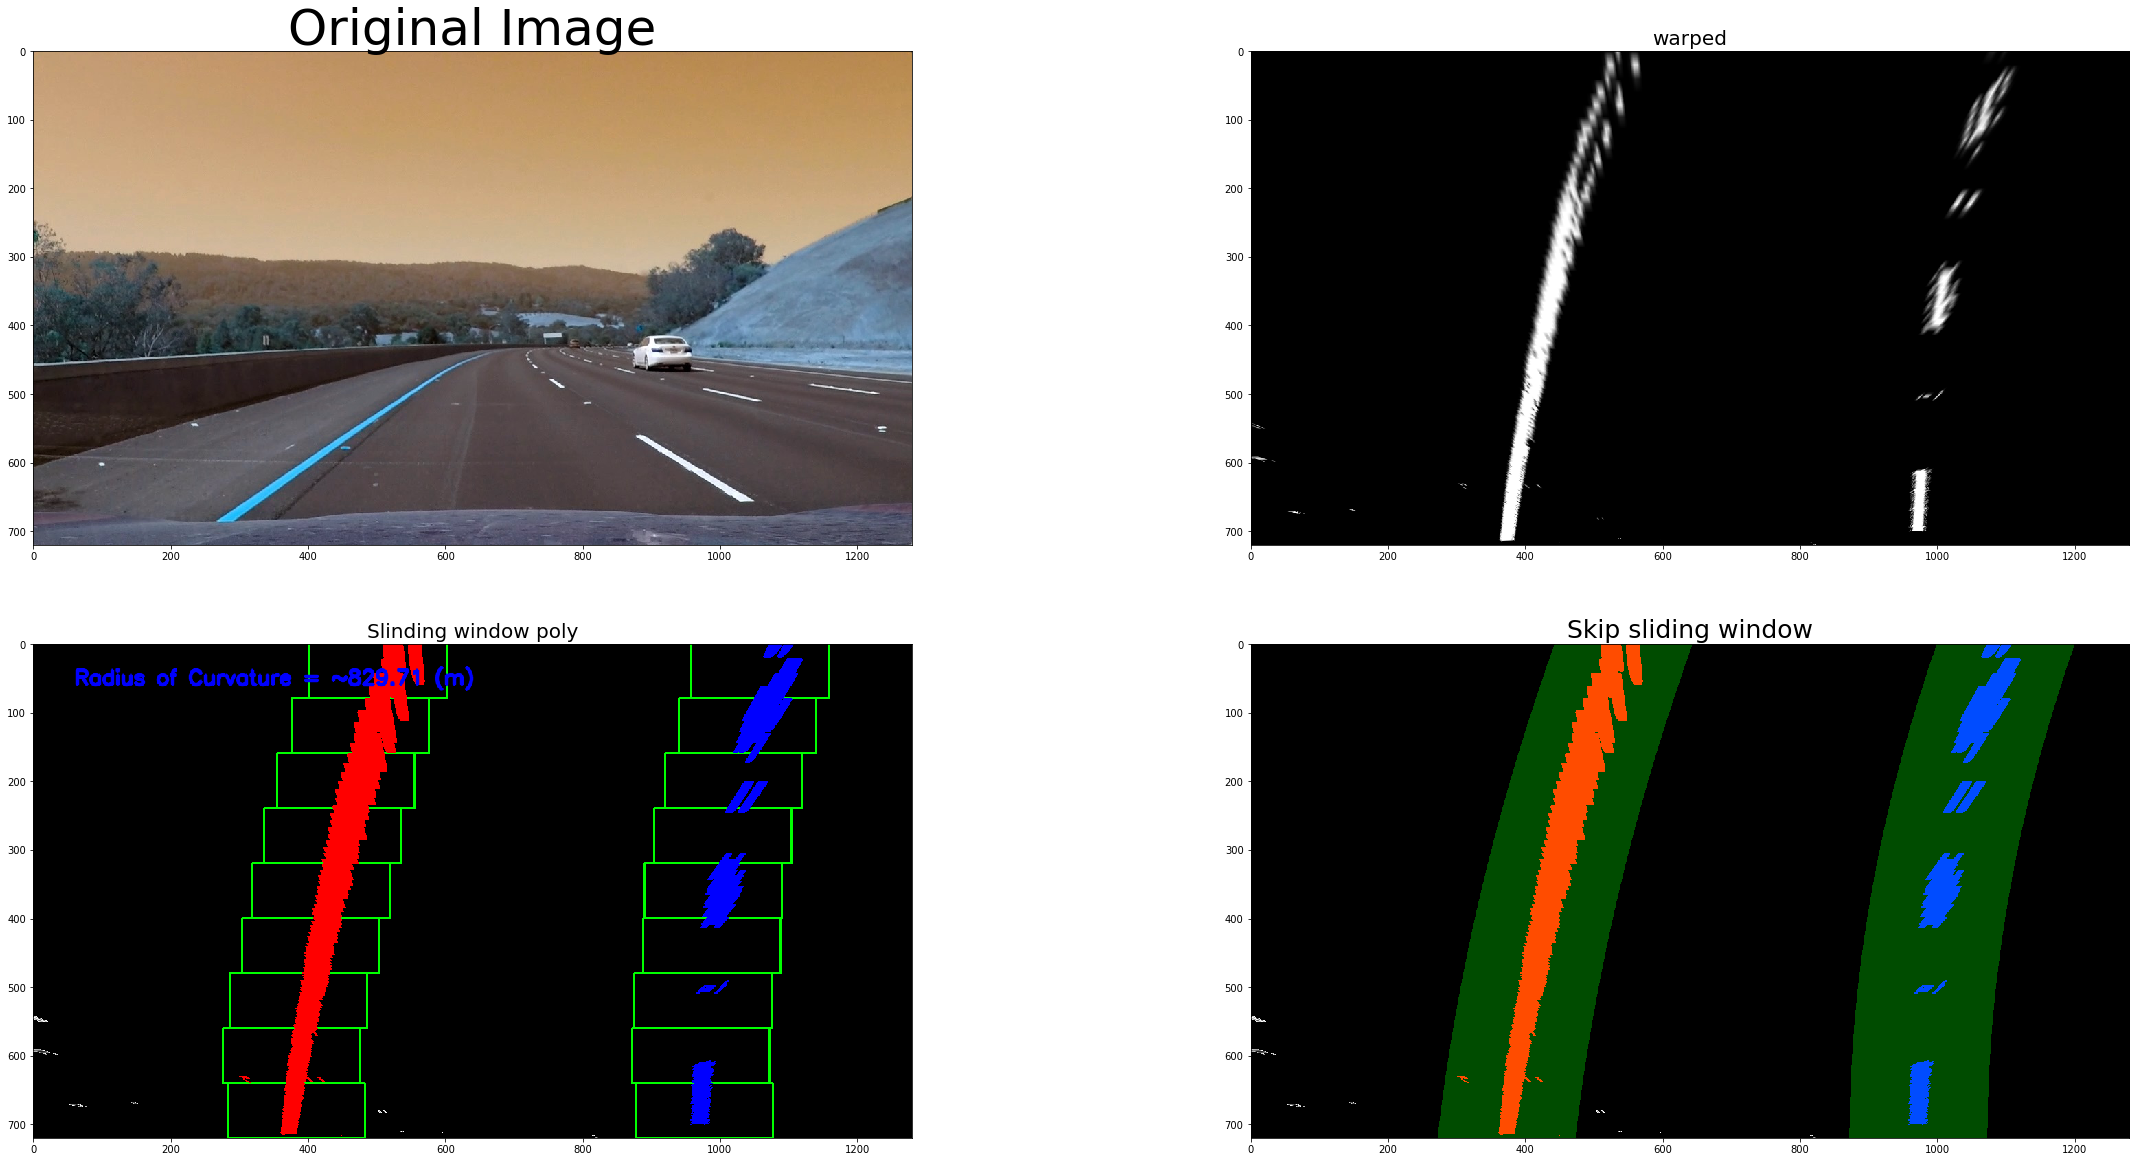

In [17]:

def pipeline5():
    img = cv2.imread("./test_images/test3.jpg")
    thresh, warped, sliding_out, skip_result = sliding_curve_plot(img)

    f, (ax1, ax2) = plt.subplots(2, 2, figsize=(40, 20))
    ax1[0].imshow(img)
    ax1[0].set_title('Original Image', fontsize=50)

    ax1[1].imshow(warped, cmap='gray')
    ax1[1].set_title('warped', fontsize=20)

    ax2[0].imshow(sliding_out, cmap='gray')
    ax2[0].set_title('Slinding window poly', fontsize=20)
    cv2.imwrite("./output_images/poly.jpg", sliding_out)
    
    ax2[1].imshow(skip_result, cmap='gray')
    ax2[1].set_title("Skip sliding window", fontsize=25)
    cv2.imwrite("./output_images/skip_poly.jpg", skip_result)
pipeline5()

### 5. calculate the radius of curvature of the lane and the position of the vehicle with respect to center.

In [18]:
def common_draw(image, binary_warped, Minv, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255, 0, 0), thickness=40)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0, 0, 255), thickness=40)
     
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
     # Find lane curvature #
    
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
   # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
  

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # print(left_curverad, 'm', right_curverad, 'm')
    radius = np.mean([left_curverad, right_curverad])
    
    #Update radius in image
    text2 = "Radius of Curvature = ~" + str(round(radius, 2)) + " (m)"
    font = cv2.FONT_HERSHEY_SIMPLEX
    result = cv2.putText(result, text2, (60, 60), font, 1, (0, 0, 255), 3, cv2.LINE_AA)

    #Update car position in image
    car_pos = binary_warped.shape[1] / 2
    lane_pos = (left_fitx[719] + right_fitx[719]) / 2
    offset = (car_pos - lane_pos) * xm_per_pix
    
    if offset > 0:
        dir = "left"
    else:
        dir = "right"
    text2 = "Vehicle is " + str(round(abs(offset), 2)) + "(m) from " + dir
    result = cv2.putText(result, text2, (60, 120), font, 1, (0, 0, 255), 3, cv2.LINE_AA)

    return result

### 6. Result plotted back down onto the road 

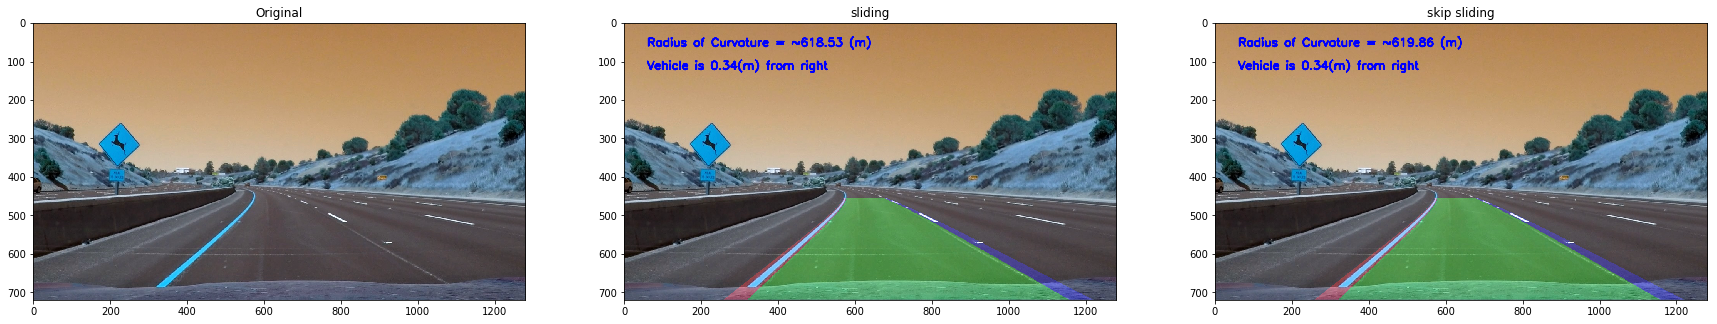

In [19]:
 def pipeline6():
    left_fit = []
    right_fit = []
    img = cv2.imread("./test_images/test2.jpg")
    images = combine(img)
    binary_warped, M, Minv = perspective_transform(images[7])
    left_fit, right_fit, left_lane_inds, right_lane_inds, dont_care = sliding_window(binary_warped)
    sliding = common_draw(img, binary_warped, Minv, left_fit, right_fit)
    left_fit, right_fit, left_lane_inds, right_lane_inds = skip_sliding(binary_warped, left_fit, right_fit)
    no_sliding = common_draw(img, binary_warped, Minv, left_fit, right_fit)

    plt.figure(figsize=[30, 40])
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1, 3, 2)
    plt.title("sliding")
    plt.imshow(sliding)
    cv2.imwrite("./output_images/sliding.jpg", sliding)

    plt.subplot(1, 3, 3)
    plt.title("skip sliding")
    plt.imshow(no_sliding)
pipeline6()

In [20]:

def init_globals():
    global first_frame
    global left_fit
    global right_fit
    first_frame = True
    left_fit = []
    right_fit = []

def process_img(img):
    global first_frame
    global left_fit
    global right_fit
    images = combine(img)
    binary_warped, M, Minv = perspective_transform(images[7])
    if first_frame == True:
        first_frame = False
        left_fit, right_fit, left_lane_inds, right_lane_inds, dont_care = sliding_window(binary_warped)
      #  print ("this is first frame")
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = skip_sliding(binary_warped, left_fit, right_fit)
    return common_draw(img, binary_warped, Minv, left_fit, right_fit)

## C. Pipeline video

In [ ]:
init_globals()

output = './output_images/project_out.mp4'
clip1 = VideoFileClip("./project_video.mp4")#.subclip(35,45)
white_clip = clip1.fl_image(process_img)
%time white_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video ./output_images/project_out.mp4
[MoviePy] Writing video ./output_images/project_out.mp4


 50%|█████     | 633/1261 [03:02<03:00,  3.48it/s]

In [ ]:
init_globals()

output = './output_images/challenge_video.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")#.subclip(35,45)
white_clip = clip1.fl_image(process_img)
%time white_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>  <source src="{0}">
</video>
""".format(output))

In [ ]:
init_globals()

output = './output_images/harder_challenge_video.mp4'
clip1 = VideoFileClip("./harder_challenge_video.mp4")#.subclip(35,45)
white_clip = clip1.fl_image(process_img)
%time white_clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>  <source src="{0}">
</video>
""".format(output))